<a href="https://colab.research.google.com/github/maurofama99/c-frames/blob/main/evaluation/cframes_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Libraries import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Mounted at /content/drive


# Design
## Policy
> ### Report
*   On Frame **Update**
*   On Frame **Close**

> ### Evict
*   Single Buffer: After **X** Frames created, evict **Y** frames
*   Multi Buffer: After **X** ms passed, evict **Y** frames
## Content and Report
With FRAMES, these two methods are managed differently w.r.t. time-driven windows. In the data-driven case, when `content` extracts the Frame of the current processed tuple, depending on the Report Policy it can happen that it is not the same content that should be reported. For instance, if the Report Policy is *On Close*, the extracted content is the just opened Frame containing only the tuple that made the last Frame being closed, instead, the reported content should be the frame of the previous processed tuple. Because of this, the `report` should not be performed on the extracted content, but on the last closed frame. In order to generalize this, for every tuple we process, we keep track and save (the timestamp of) the Frame that should be reported, that indeed could not be (the timestamp of) the Frame of the current processed tuple. With this design, `content` do not extract anymore the Frame of the current tuple every `tick`, but extract the content of the pointed Frame every time a particular action is performed.
## Linked List and Binary Search
To implement the single buffer, we used a Linked List, instead, Binary Search algorithm is designed for array-like data structure. For this reason, even if the buffer is sorted, we cannot achieve an exact *O(logn)* time complexity, but still a sub-linear time complexity. \
https://stackoverflow.com/questions/5281053/how-to-apply-binary-search-olog-n-on-a-sorted-linked-list

# Single buffer

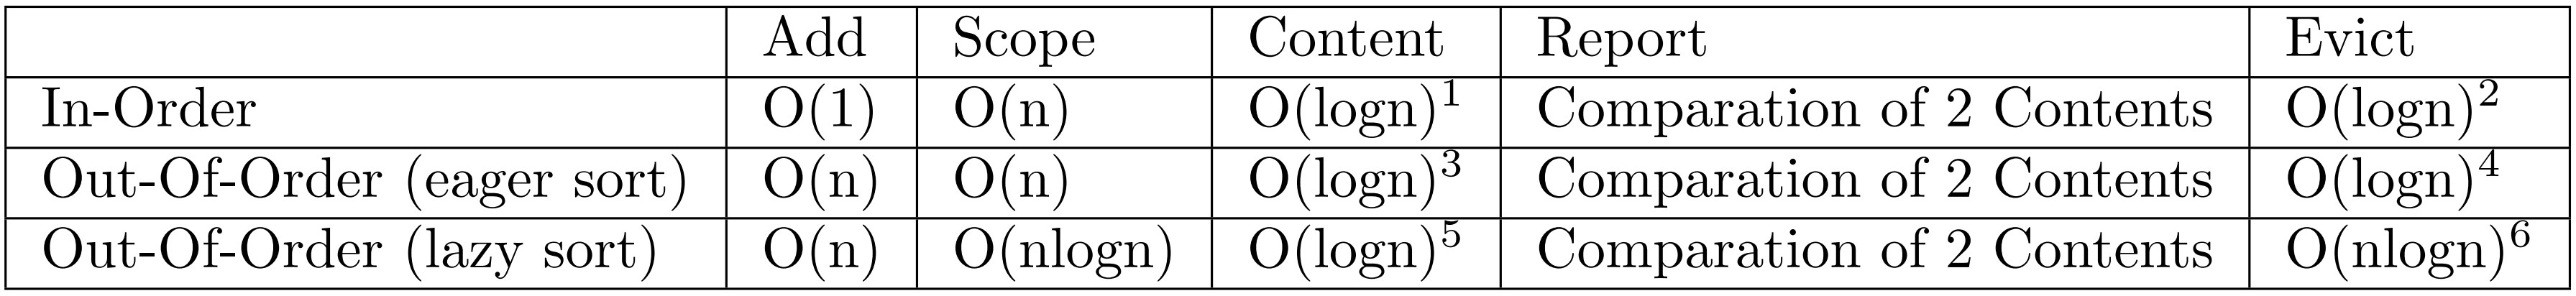
n = size of buffer \
lazy sort: buffer not ordered add in O(1)

## In-Order

#### CSV load
Select the path of the csv representing the execution

In [2]:
sb_ne = 'output_0_0_-1.csv'
sb_e = 'output_0_0_6000.csv'
sb_ne_path = '/content/drive/My Drive/cframes/' + sb_ne # Single Buffer, In order, No Eviction
sb_e_path = '/content/drive/My Drive/cframes/' + sb_e # Single Buffer, In order, Eviction

### No Eviction

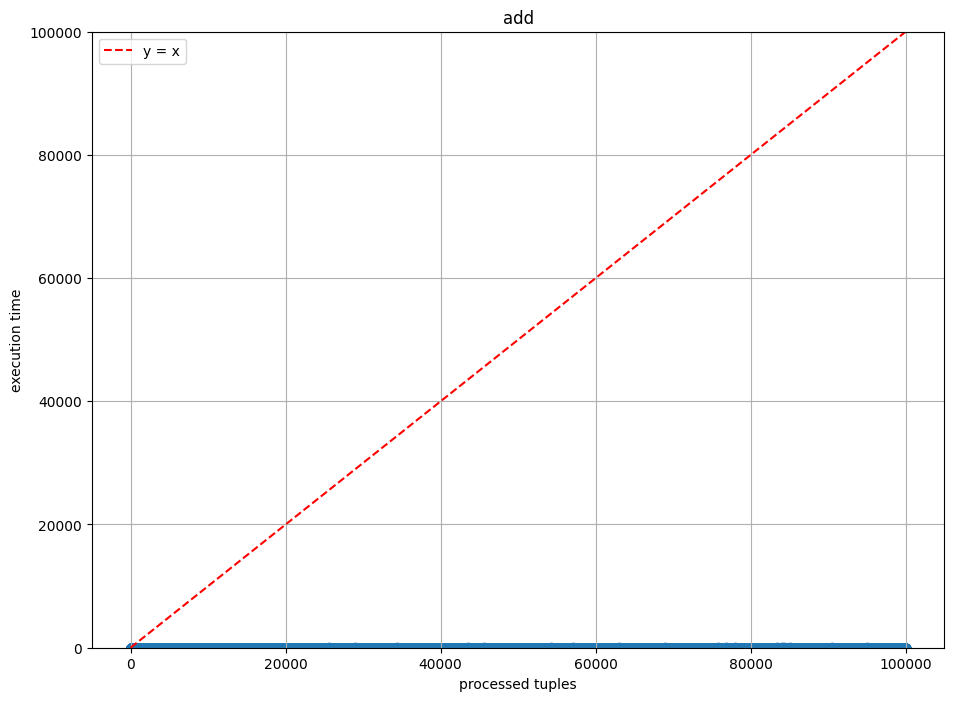

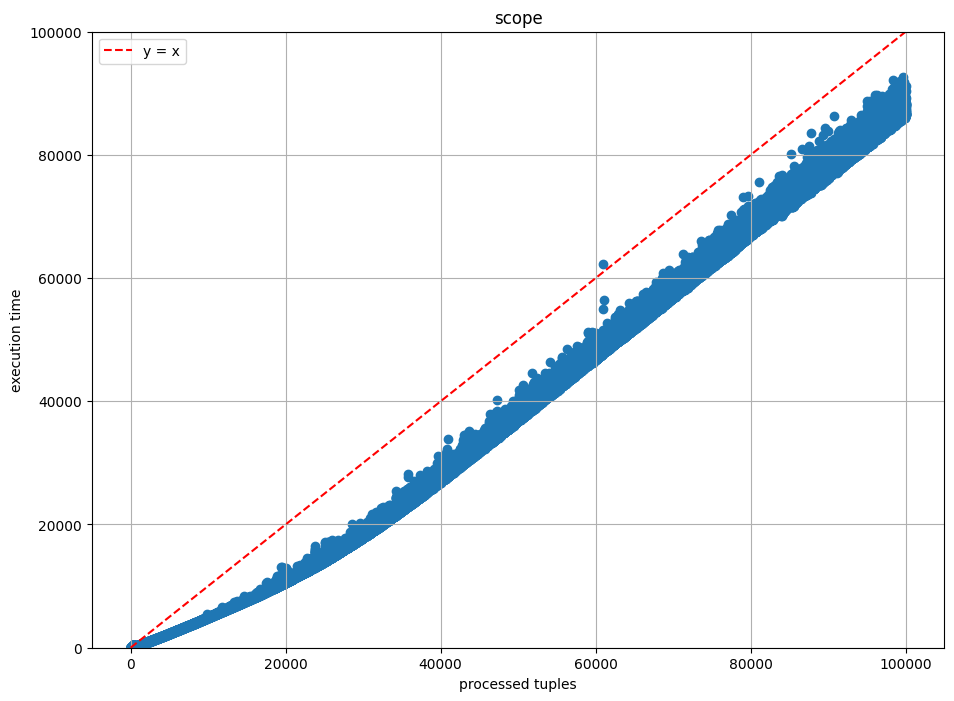

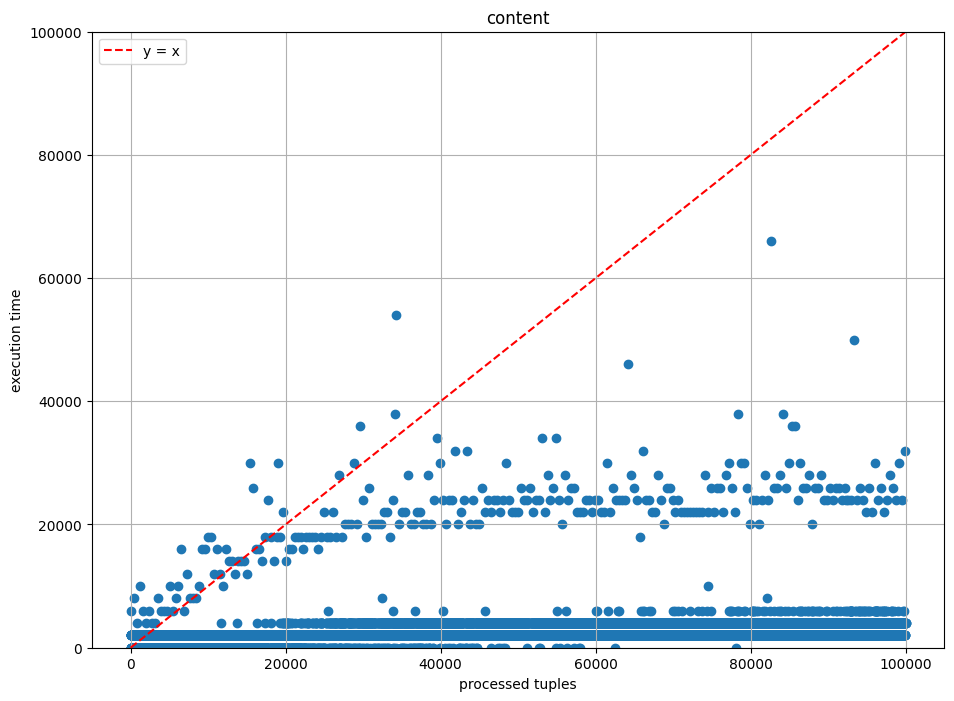

In [25]:
# select path
df = pd.read_csv(sb_ne_path)

multiplier = 2000000 # time scaling for better analysis

df['add'] *= multiplier
df['scope'] *= multiplier
df['content'] *= multiplier * 1000

methods = ['add', 'scope', 'content']

def linear_function(x):
    return x

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1*multiplier)]

    plt.figure(figsize=(11, 8))
    plt.scatter(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values)
    plt.plot(x_values, y_values, linestyle='--', label='y = x', color = 'red')

    plt.ylim(-10, 100000)
    plt.title(f'{method}')
    plt.xlabel('processed tuples')
    plt.ylabel(f'execution time')
    plt.legend()
    plt.grid(True)

    plt.show()


### With Eviction

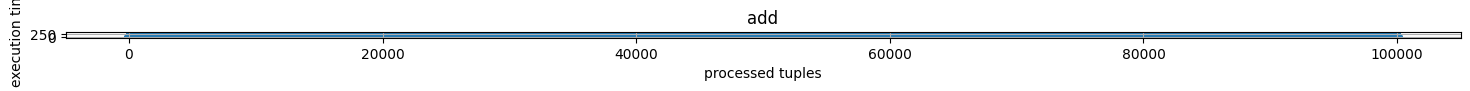

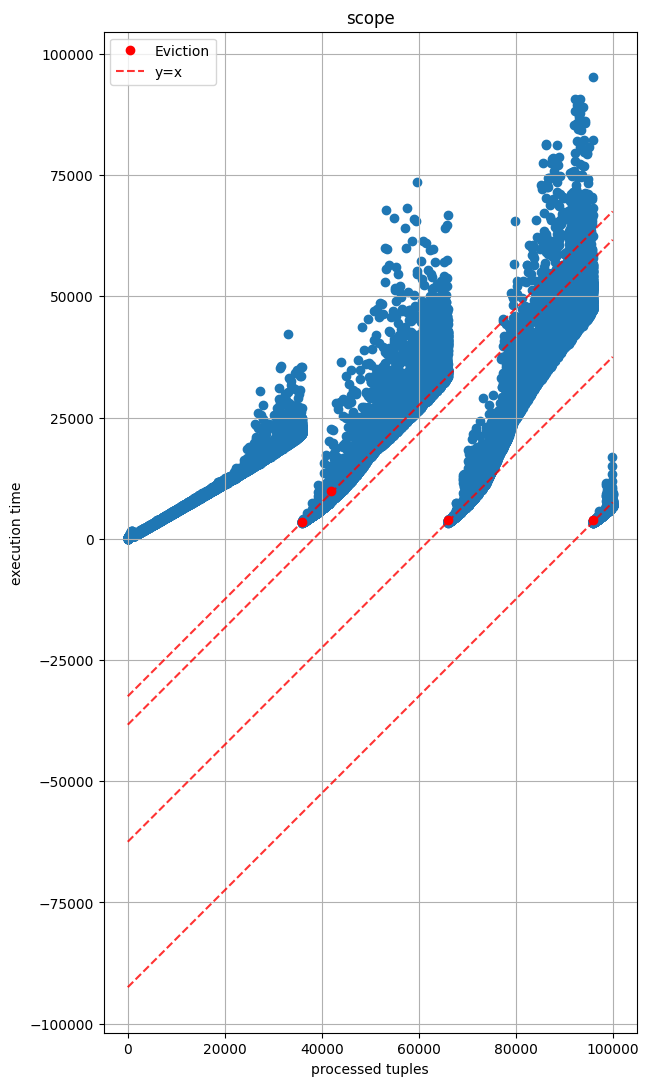

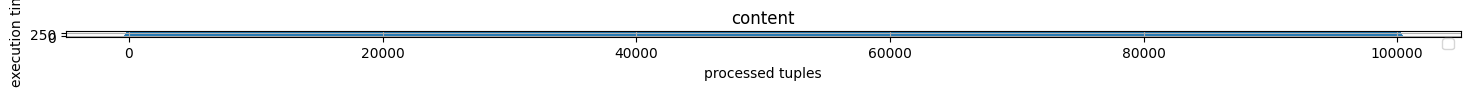

<ipython-input-4-ffd4e5918716>:66: RuntimeWarning: invalid value encountered in log
  y_log = np.log(x_log - 25000) *1000


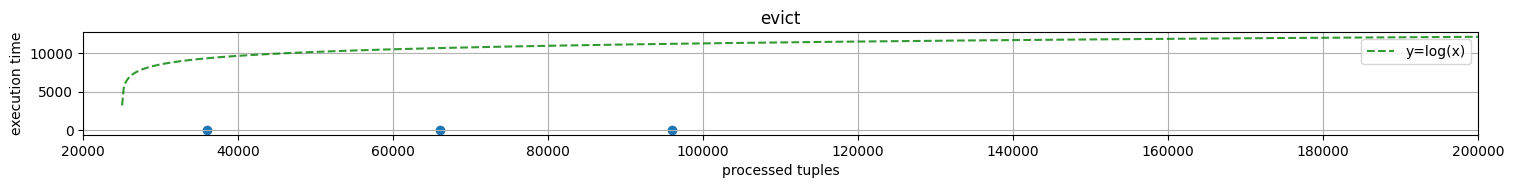

In [4]:
from pickle import FALSE
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# select path
df = pd.read_csv(sb_e_path)

multiplier = 20000000  # time scaling for better analysis

df['add'] *= multiplier
df['scope'] *= multiplier
df['content'] *= multiplier
df['evict'] *= multiplier

methods = ['add', 'scope', 'content', 'evict']

def linear_function(x, x0, y0):
    return (x - x0) + y0

thresholds = {
    'add': {'delta_threshold': 12000, 'threshold_value': 10000},
    'scope': {'delta_threshold': 12000, 'threshold_value': 10000},
    'content': {'delta_threshold': 3200, 'threshold_value': 4000},
    'evict': {'delta_threshold': 3200, 'threshold_value': 4000}
}

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1 * multiplier)]

    plt.figure(figsize=(18, 13))
    plt.scatter(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values, 0, 0)

    delta_threshold = thresholds[method]['delta_threshold']
    threshold_value = thresholds[method]['threshold_value']
    discontinuity_points = []

    for i in range(1, len(method_data)):
        delta = abs(method_data[method].iloc[i] - method_data[method].iloc[i - 1])
        if delta >= delta_threshold and method_data[method].iloc[i] <= threshold_value:
            discontinuity_points.append(method_data.iloc[i])

    if discontinuity_points:
        discontinuity_points = pd.DataFrame(discontinuity_points)

        plt.plot(discontinuity_points['n'], discontinuity_points[method], 'ro', label='Eviction')

        first = 0
        for n_discontinuity in discontinuity_points['n']:
            y_values_discontinuity = linear_function(x_values, n_discontinuity-3500, 0)
            if (first == 0):
              plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8, label='y=x')
              first = 1
            else :
              plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8)

    if method == 'evict':
        x_log = np.linspace(0, 200000, 1000)  # Crea un array di valori x logaritmici
        y_log = np.log(x_log - 25000) *1000
        plt.plot(x_log, y_log, linestyle='--', color='green', alpha=0.8, label='y=log(x)')


    plt.grid(True)
    ax = plt.gca()

    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.title(f'{method}')
    plt.xlabel('processed tuples')
    plt.ylabel(f'execution time')
    #plt.ylim(-10,25000)
    if(method == 'evict'): plt.xlim(20000,200000)
    if(method != 'add'): plt.legend()

    plt.show()


## Out-of-Order (eager sort)

### CSV load

In [28]:
sb_ne_oooe = 'output_1_0_-1.csv'
sb_e_oooe = 'output_1_0_6000.csv'
sb_ne_path = '/content/drive/My Drive/cframes/' + sb_ne_oooe # Single Buffer, Out of order (eager sort), No Eviction
sb_e_path = '/content/drive/My Drive/cframes/' + sb_e_oooe # Single Buffer, Out of order (eager sort), Eviction

### No Eviction

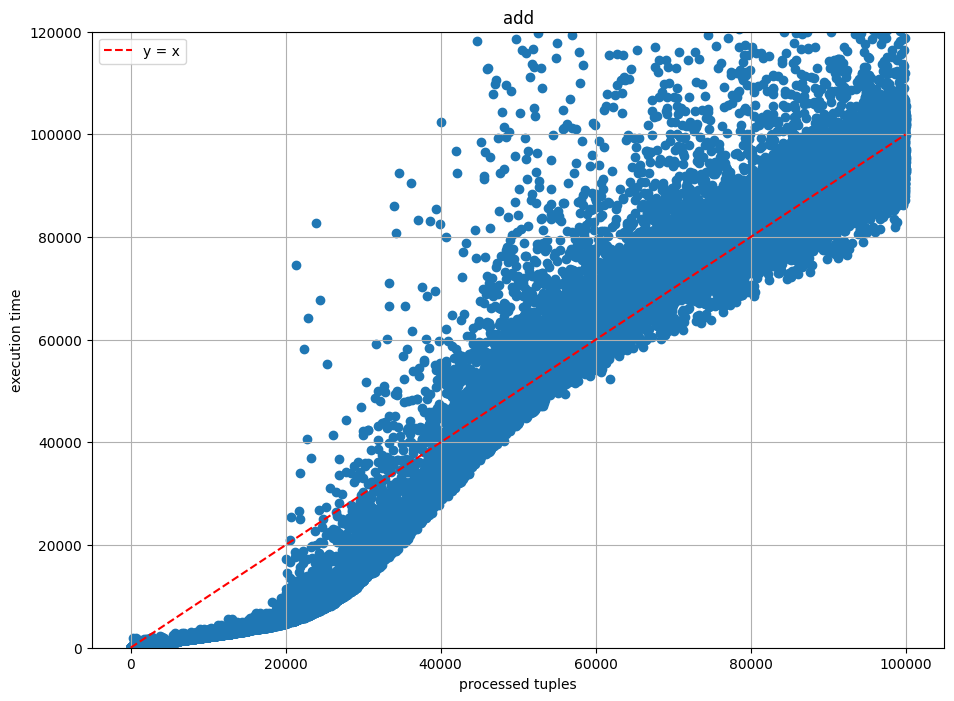

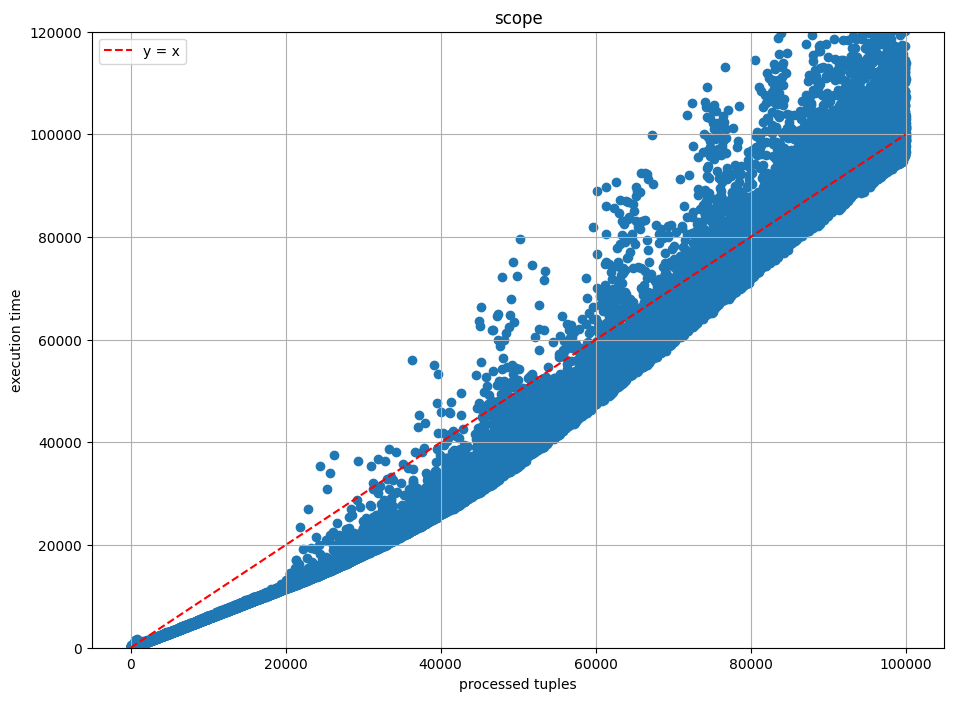

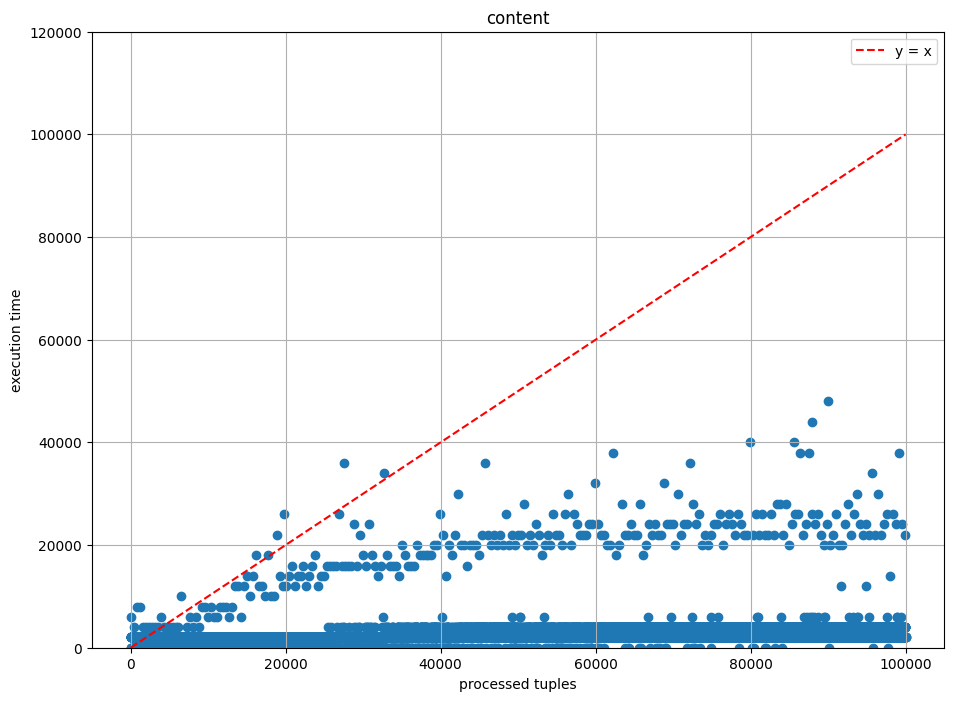

In [38]:
# select path
df = pd.read_csv(sb_ne_path)

multiplier = 20000000 # time scaling for better analysis

df['add'] *= multiplier*5
df['scope'] *= multiplier
df['content'] *= multiplier*100

methods = ['add', 'scope', 'content']

def linear_function(x):
    return x

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1*multiplier)]

    plt.figure(figsize=(11, 8))
    plt.scatter(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values)
    plt.plot(x_values, y_values, linestyle='--', label='y = x', color = 'red')

    plt.ylim(-10, 120000)
    plt.title(f'{method}')
    plt.xlabel('processed tuples')
    plt.ylabel(f'execution time')
    plt.legend()
    plt.grid(True)

    plt.show()


### With Eviction

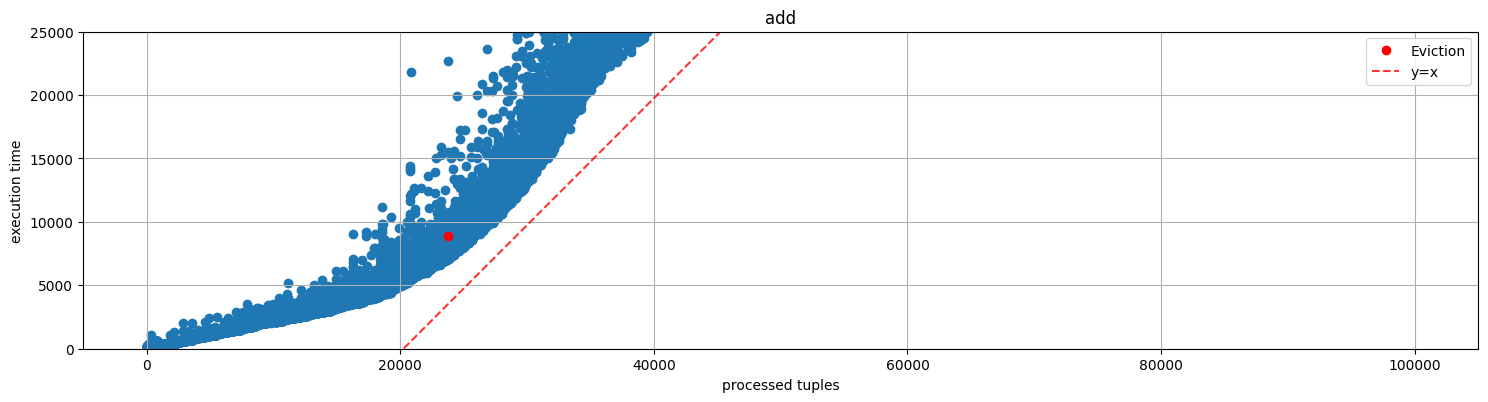

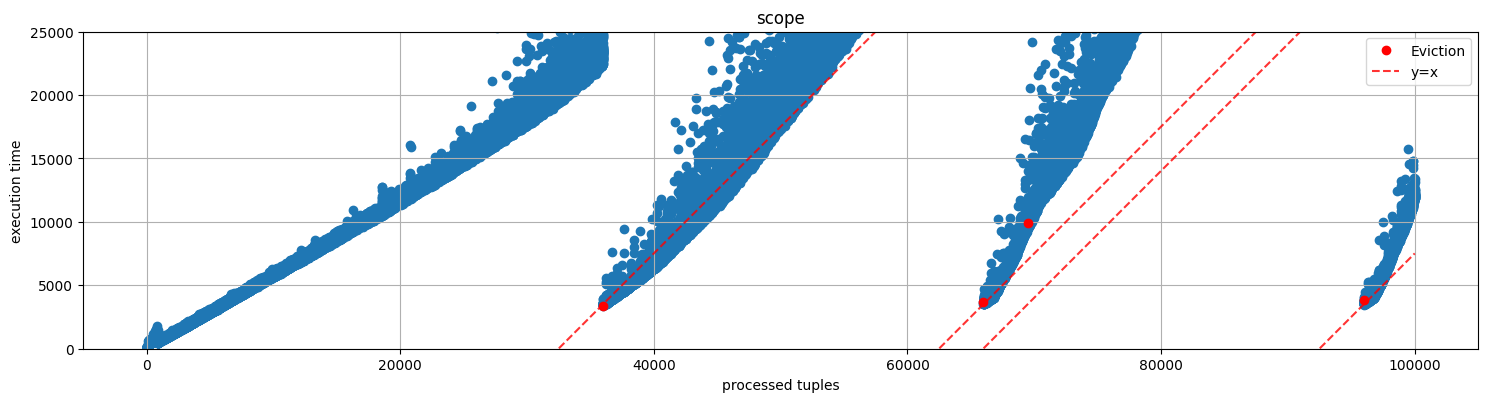

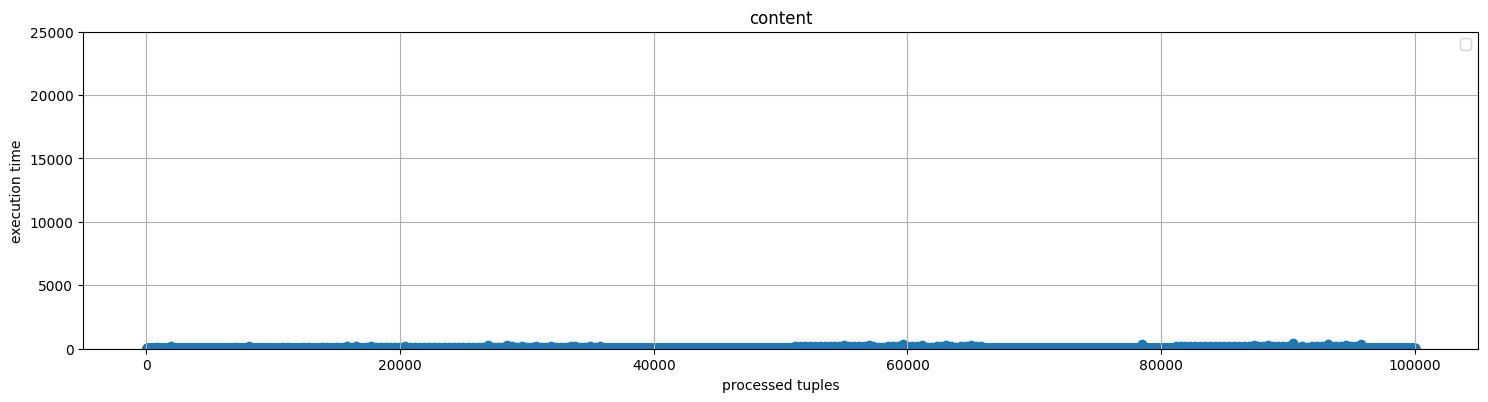

<ipython-input-7-7dd55f410e28>:66: RuntimeWarning: invalid value encountered in log
  y_log = np.log(x_log - 25000) *1000


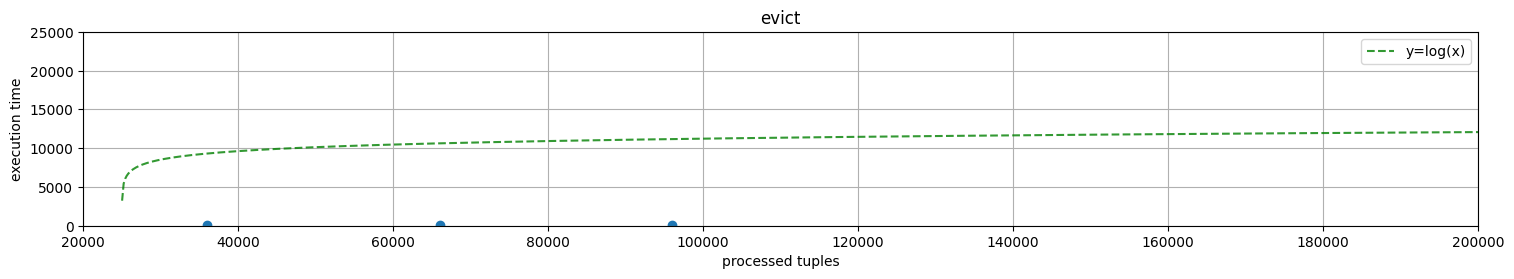

In [7]:
from pickle import FALSE
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# select path
df = pd.read_csv(sb_e_path)

multiplier = 20000000  # time scaling for better analysis

df['add'] *= multiplier*5
df['scope'] *= multiplier
df['content'] *= multiplier
df['evict'] *= multiplier

methods = ['add', 'scope', 'content', 'evict']

def linear_function(x, x0, y0):
    return (x - x0) + y0

thresholds = {
    'add': {'delta_threshold': 12000, 'threshold_value': 10000},
    'scope': {'delta_threshold': 11000, 'threshold_value': 10000},
    'content': {'delta_threshold': 3200, 'threshold_value': 4000},
    'evict': {'delta_threshold': 3200, 'threshold_value': 4000}
}

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1 * multiplier)]

    plt.figure(figsize=(18, 13))
    plt.scatter(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values, 0, 0)

    delta_threshold = thresholds[method]['delta_threshold']
    threshold_value = thresholds[method]['threshold_value']
    discontinuity_points = []

    for i in range(1, len(method_data)):
        delta = abs(method_data[method].iloc[i] - method_data[method].iloc[i - 1])
        if delta >= delta_threshold and method_data[method].iloc[i] <= threshold_value:
            discontinuity_points.append(method_data.iloc[i])

    if discontinuity_points:
        discontinuity_points = pd.DataFrame(discontinuity_points)

        plt.plot(discontinuity_points['n'], discontinuity_points[method], 'ro', label='Eviction')

        first = 0
        for n_discontinuity in discontinuity_points['n']:
            y_values_discontinuity = linear_function(x_values, n_discontinuity-3500, 0)
            if (first == 0):
              plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8, label='y=x')
              first = 1
            else :
              plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8)

    if method == 'evict':
        x_log = np.linspace(0, 200000, 1000)  # Crea un array di valori x logaritmici
        y_log = np.log(x_log - 25000) *1000
        plt.plot(x_log, y_log, linestyle='--', color='green', alpha=0.8, label='y=log(x)')


    plt.grid(True)
    ax = plt.gca()

    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.title(f'{method}')
    plt.xlabel('processed tuples')
    plt.ylabel(f'execution time')
    plt.ylim(-10,25000)
    if(method == 'evict'): plt.xlim(20000,200000)
    plt.legend()

    plt.show()


## Out-of-Order (lazy sort)



### CSV load

In [39]:
sb_ne_oooe = 'output_2_0_-1.csv'
sb_e_oooe = 'output_2_0_6000.csv'
sb_ne_path = '/content/drive/My Drive/cframes/' + sb_ne_oooe # Single Buffer, Out of order (eager sort), No Eviction
sb_e_path = '/content/drive/My Drive/cframes/' + sb_e_oooe # Single Buffer, Out of order (eager sort), Eviction

### No Eviction

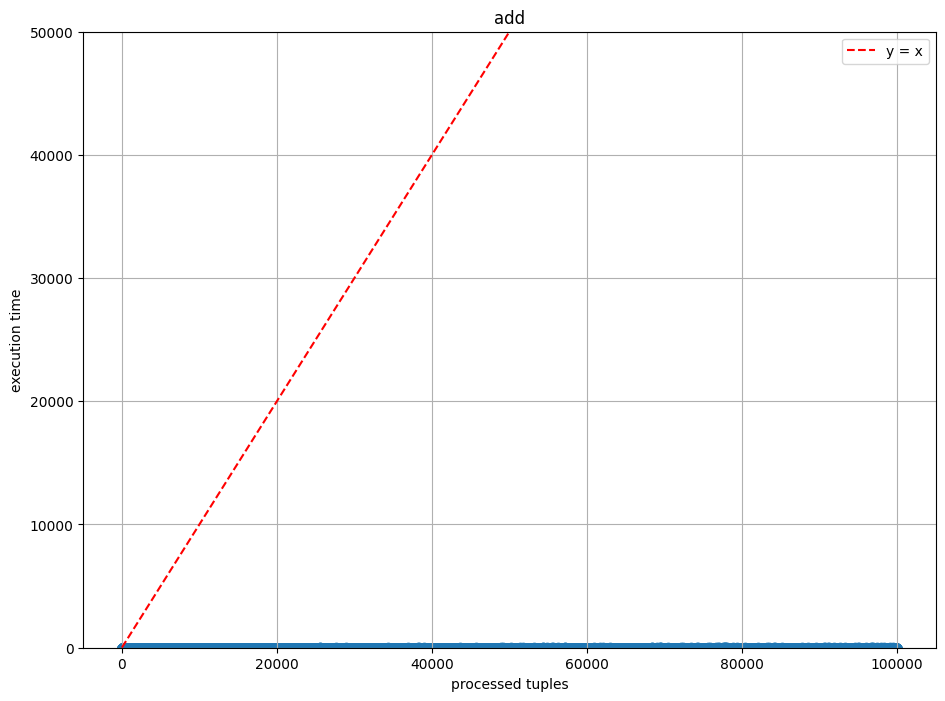

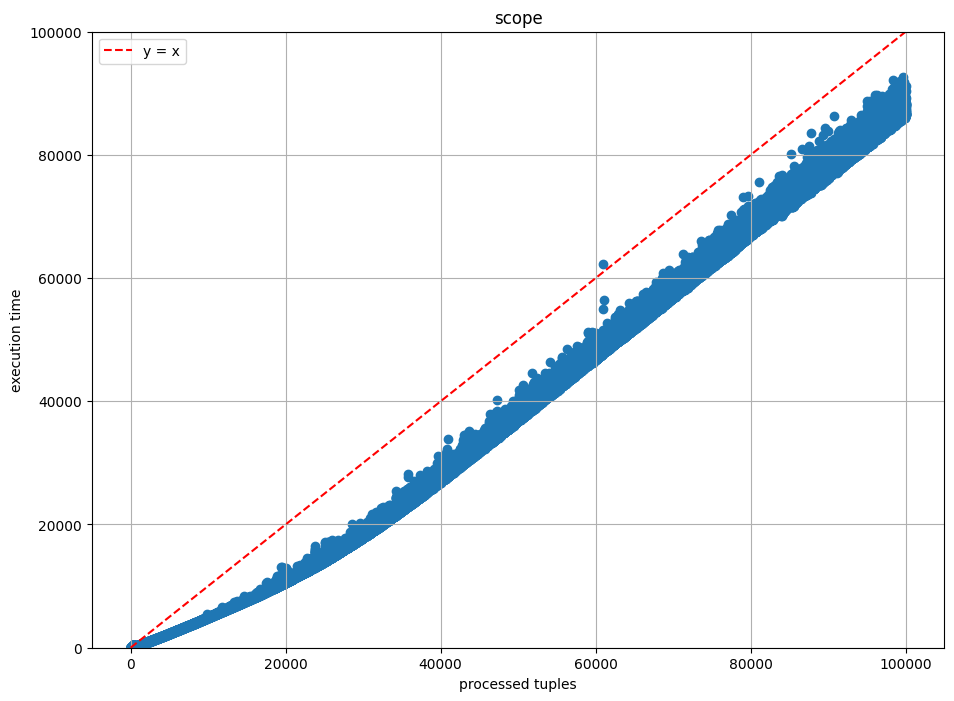

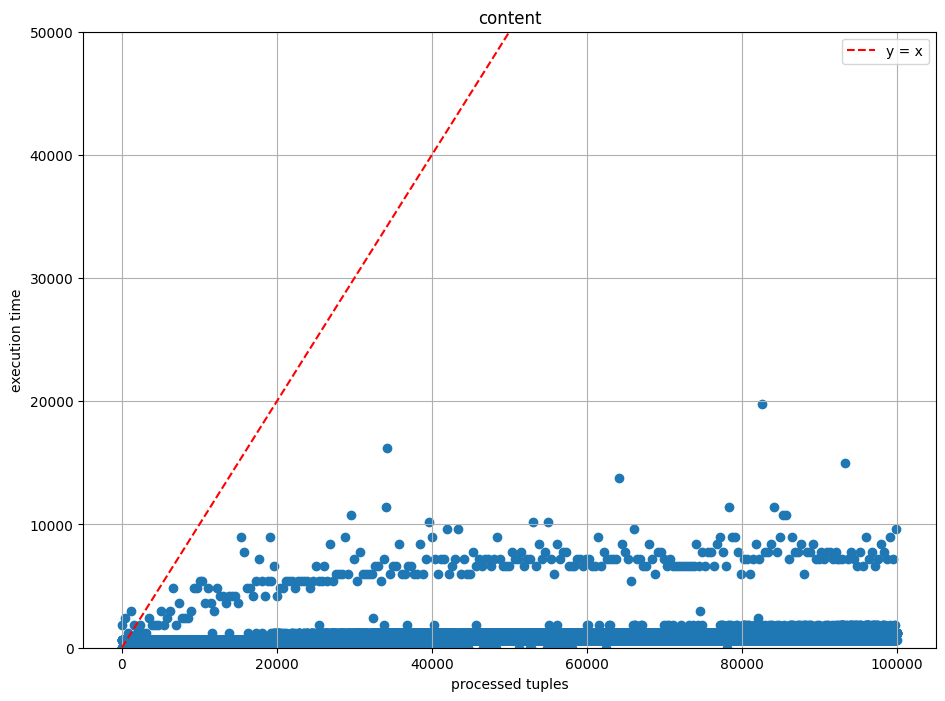

In [46]:
# select path
df = pd.read_csv(sb_ne_path)

multiplier = 2000000 # time scaling for better analysis

df['add'] *= multiplier
df['scope'] *= multiplier
df['content'] *= multiplier * 300

methods = ['add', 'scope', 'content']

def linear_function(x):
    return x

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1*multiplier)]

    plt.figure(figsize=(11, 8))
    plt.scatter(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values)
    plt.plot(x_values, y_values, linestyle='--', label='y = x', color = 'red')

    if(method == 'scope'): plt.ylim(-10, 100000)
    else: plt.ylim(-10, 50000)
    plt.title(f'{method}')
    plt.xlabel('processed tuples')
    plt.ylabel(f'execution time')
    plt.legend()
    plt.grid(True)

    plt.show()


### With Eviction

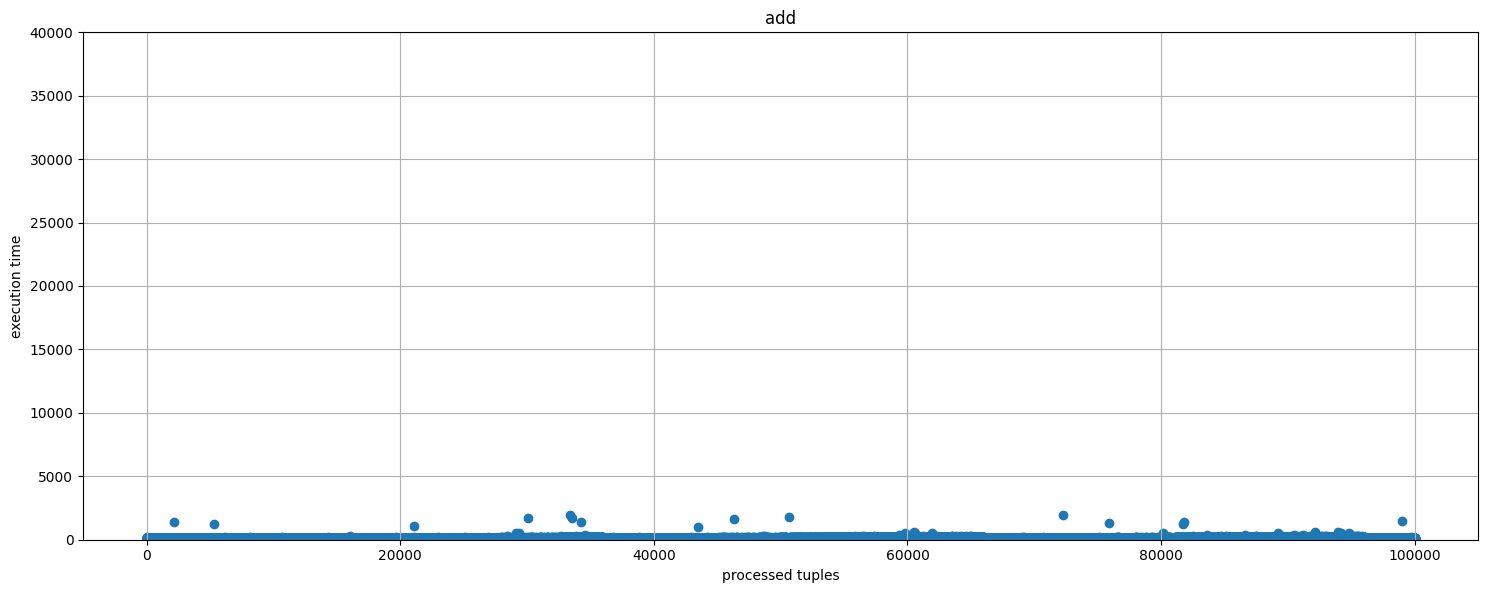

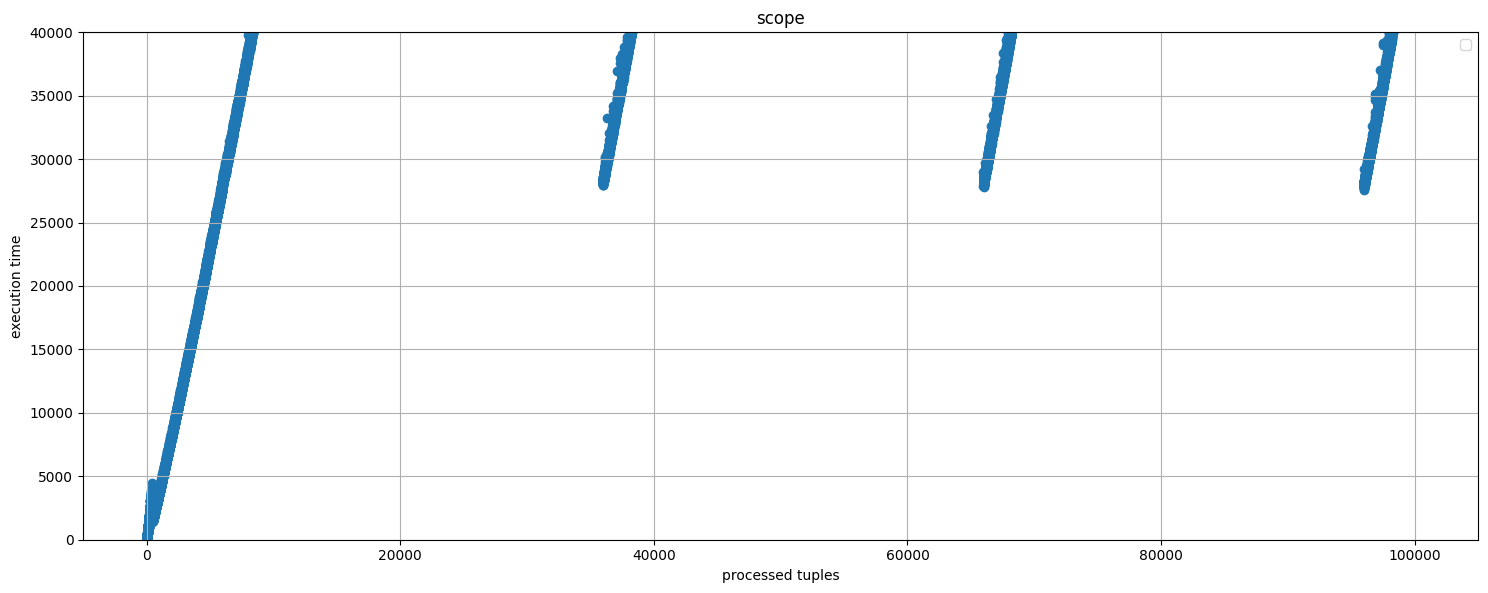

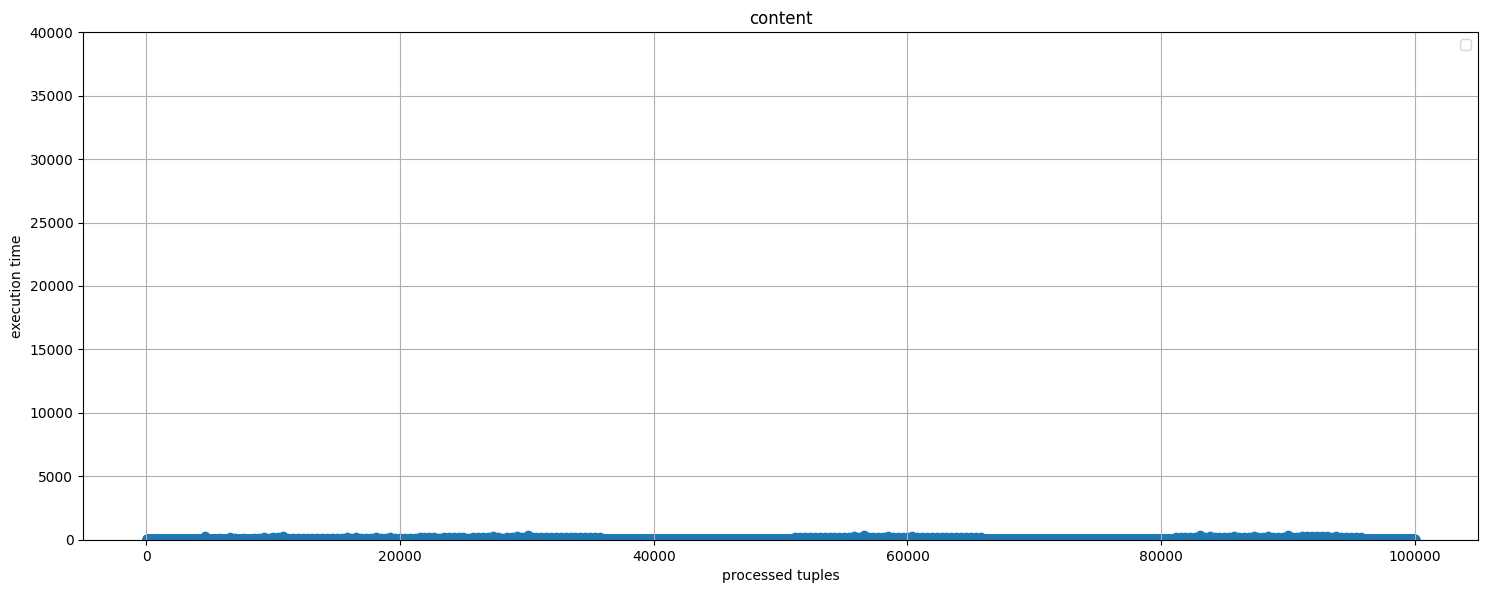

<ipython-input-10-0904cbc8dac4>:68: RuntimeWarning: invalid value encountered in log
  y_log = np.log(x_log - 25000) *1000


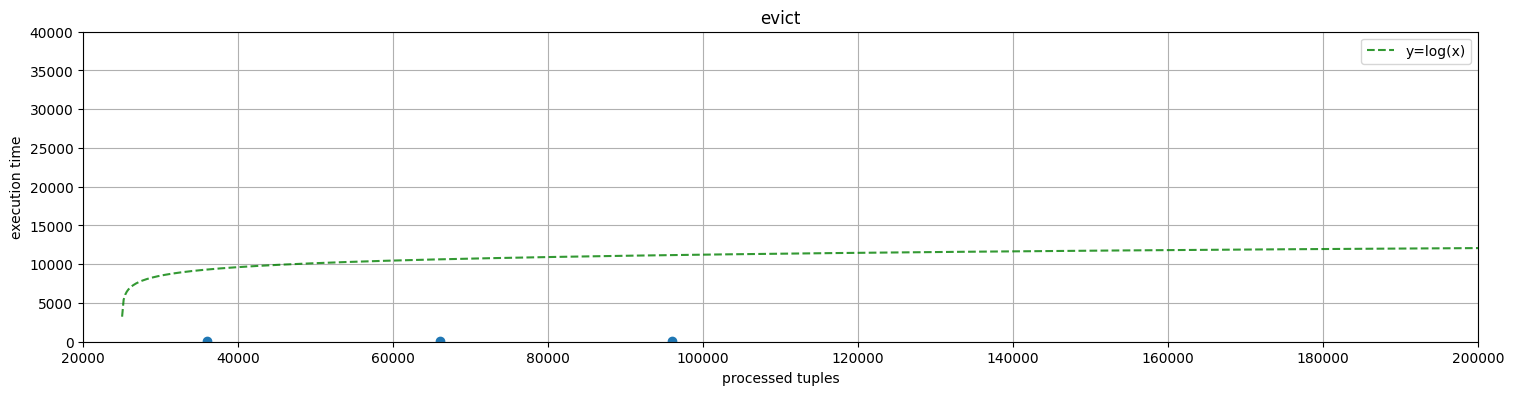

In [10]:
from pickle import FALSE
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# select path
df = pd.read_csv(sb_e_path)

multiplier = 20000000  # time scaling for better analysis

df['add'] *= multiplier*5
df['scope'] *= multiplier
df['content'] *= multiplier
df['evict'] *= multiplier

methods = ['add', 'scope', 'content', 'evict']

def linear_function(x, x0, y0):
    return (x - x0) + y0

thresholds = {
    'add': {'delta_threshold': 12000, 'threshold_value': 10000},
    'scope': {'delta_threshold': 21000, 'threshold_value': 20000},
    'content': {'delta_threshold': 5000, 'threshold_value': 4000},
    'evict': {'delta_threshold': 3200, 'threshold_value': 4000}
}

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1 * multiplier)]

    plt.figure(figsize=(18, 13))
    plt.scatter(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values, 0, 0)

    delta_threshold = thresholds[method]['delta_threshold']
    threshold_value = thresholds[method]['threshold_value']
    discontinuity_points = []

    for i in range(1, len(method_data)):
        delta = abs(method_data[method].iloc[i] - method_data[method].iloc[i - 1])
        if delta >= delta_threshold and method_data[method].iloc[i] <= threshold_value:
            discontinuity_points.append(method_data.iloc[i])

    if discontinuity_points:
        discontinuity_points = pd.DataFrame(discontinuity_points)

        plt.plot(discontinuity_points['n'], discontinuity_points[method], 'ro', label='Eviction')

        first = 0
        for n_discontinuity in discontinuity_points['n']:
            x_values = np.linspace(0, 200000, 1000)
            if(method == 'content'): y_values_discontinuity = linear_function(x_values, n_discontinuity -2000, 500)
            if(method == 'scope'): y_values_discontinuity = linear_function(x_values, (n_discontinuity -8000), 3000)
            if (first == 0):
              plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8, label='y=x')
              first = 1
            else :
              plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8)

    if method == 'evict':
        x_log = np.linspace(0, 200000, 1000)  # Crea un array di valori x logaritmici
        y_log = np.log(x_log - 25000) *1000
        plt.plot(x_log, y_log, linestyle='--', color='green', alpha=0.8, label='y=log(x)')


    plt.grid(True)
    ax = plt.gca()

    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.title(f'{method}')
    plt.xlabel('processed tuples')
    plt.ylabel(f'execution time')
    plt.ylim(-10,40000)
    if(method == 'evict'): plt.xlim(20000,200000)
    if(method != 'add'):plt.legend()

    plt.show()


# Multi-Buffer

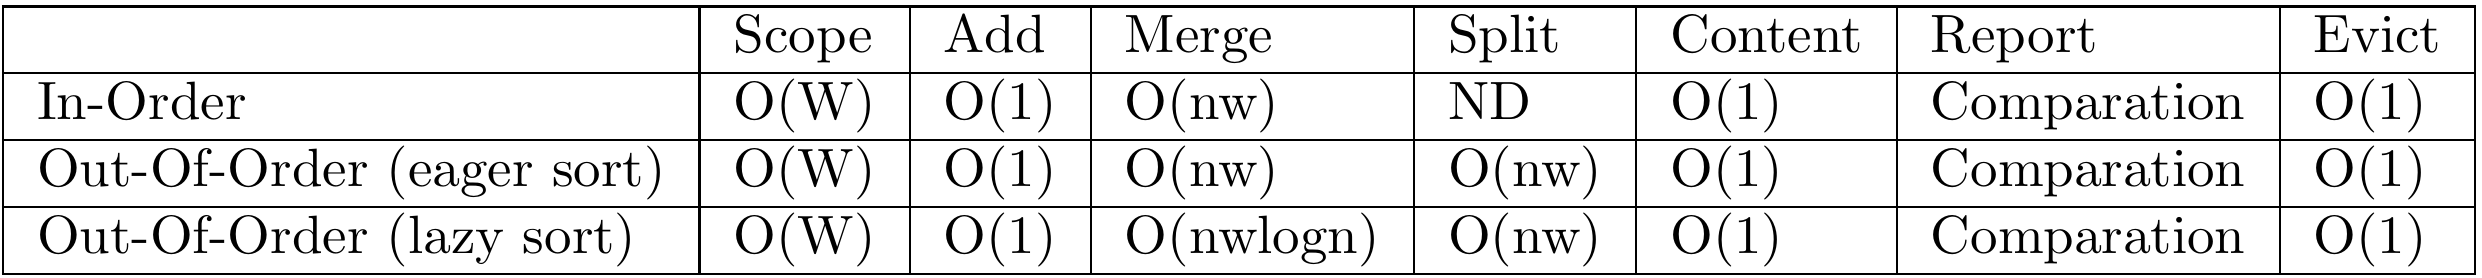
n = size of buffer, w = number of buffers, W = w + freshly created buffers

### Implementation
At tuple arrival, traverse all the existing frames in *O(W)*, find the respective frame and add the tuple to it in *O(1)*. \
**Data Structure:**
An array of lists, each element represents a frame, points to the list of tuples contained into the frame. Array access in *O(1)*.

## In-Order

#### CSV load

In [11]:
mb_ne = 'output_0_1_-1.csv'
mb_e = 'output_0_1_34000000.csv'
mb_ne_path = '/content/drive/My Drive/cframes/' + mb_ne # Multi Buffer, In Order, No Eviction
mb_e_path = '/content/drive/My Drive/cframes/' + mb_e # Mulit Buffer, In Order, Eviction

### No Eviction

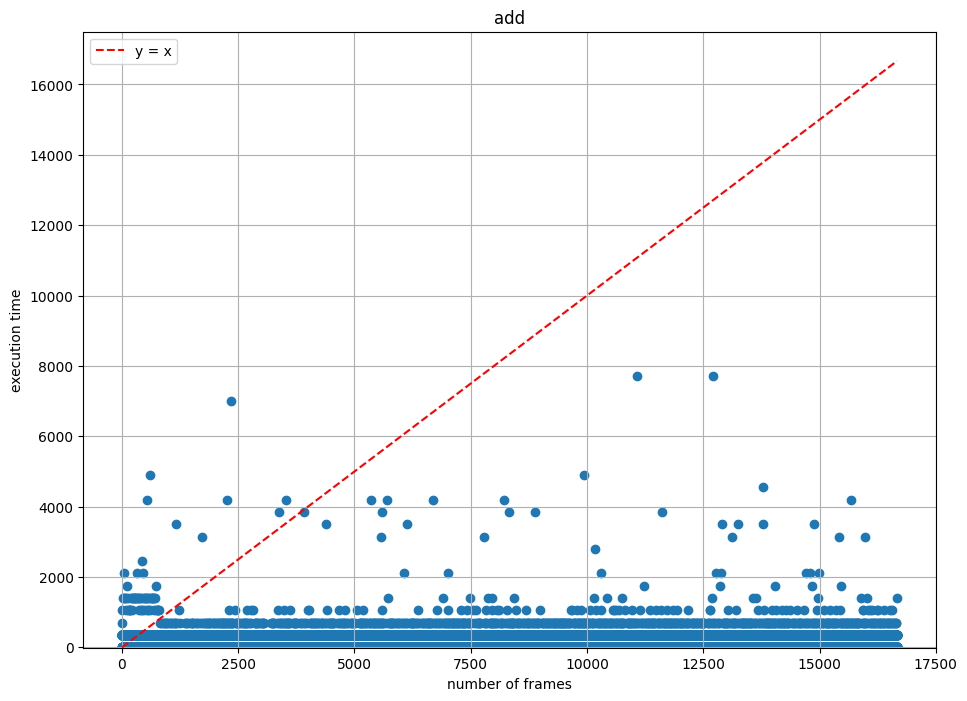

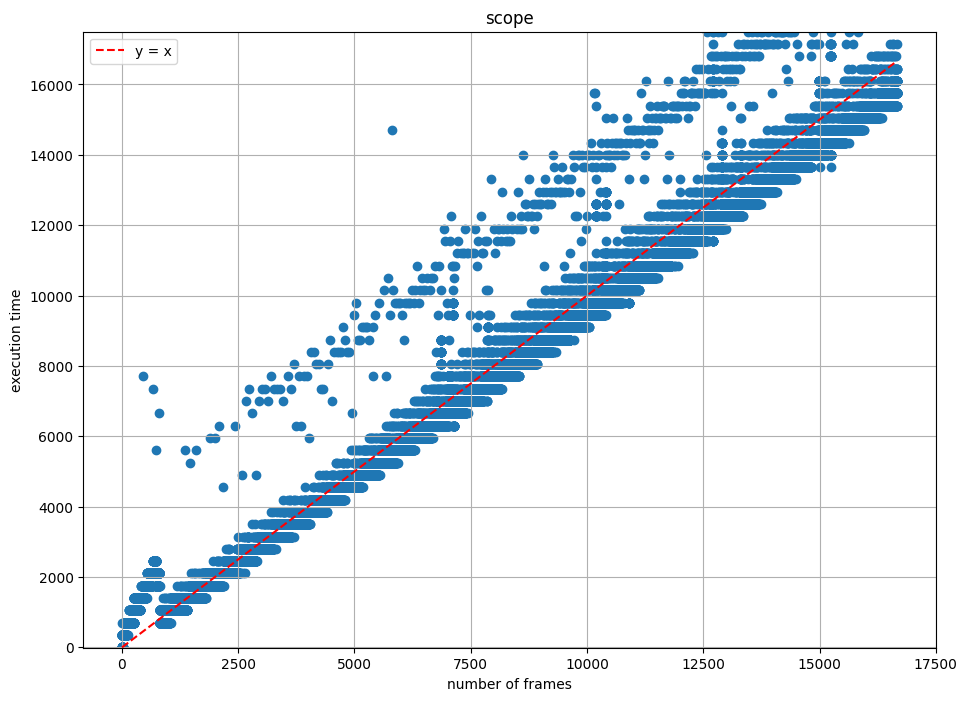

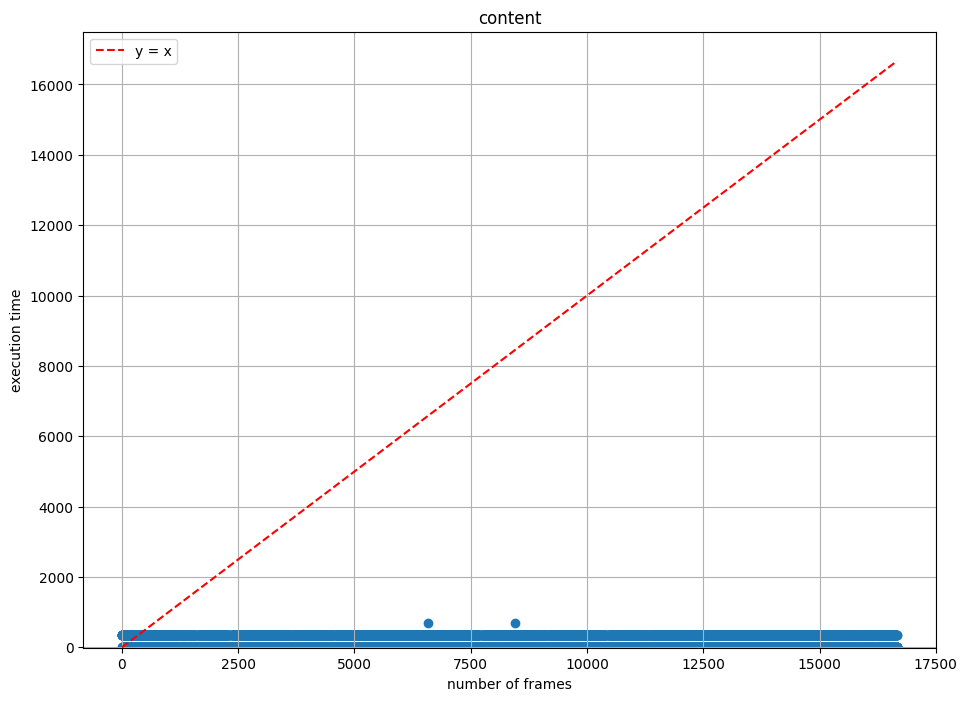

In [50]:
# select path
df = pd.read_csv(mb_ne_path)

multiplier = 350000000 # time scaling for better analysis

df['add'] *= multiplier
df['scope'] *= multiplier
df['content'] *= multiplier

methods = ['add', 'scope', 'content']

def linear_function(x):
    return x

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1*multiplier)]

    plt.figure(figsize=(11, 8))
    if(method != 'evict'): plt.scatter(method_data['n'], method_data[method], marker='o')
    if(method == 'evict'): plt.plot(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values)
    plt.plot(x_values, y_values, linestyle='--', label='y = x', color = 'red')

    plt.ylim(-10, 17500)
    plt.title(f'{method}')
    plt.xlabel('number of frames')
    plt.ylabel(f'execution time')
    plt.legend()
    plt.grid(True)

    plt.show()


### With Eviction

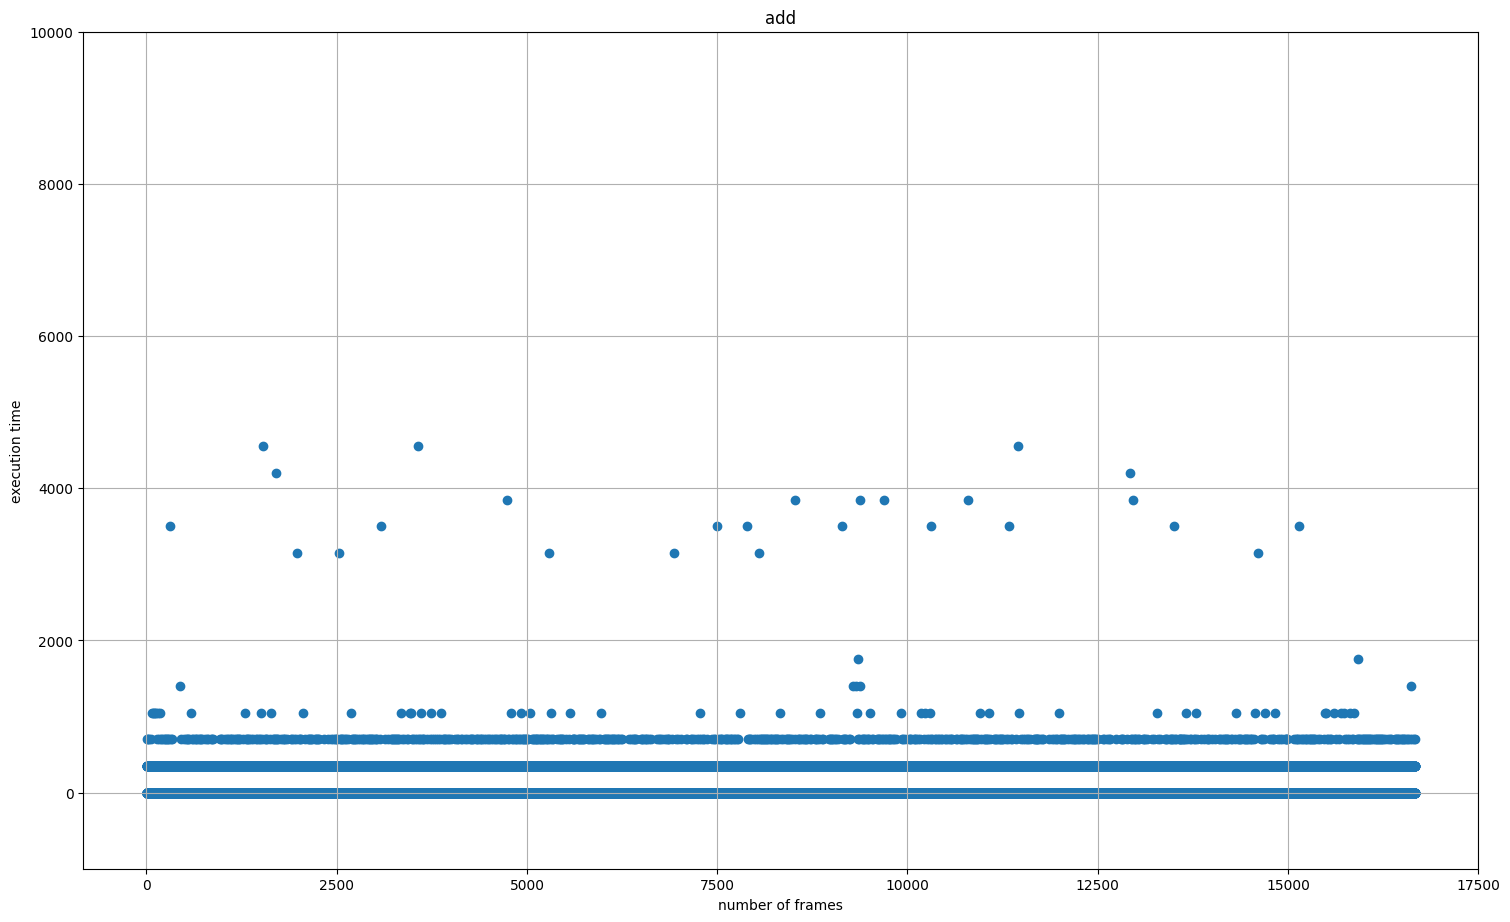

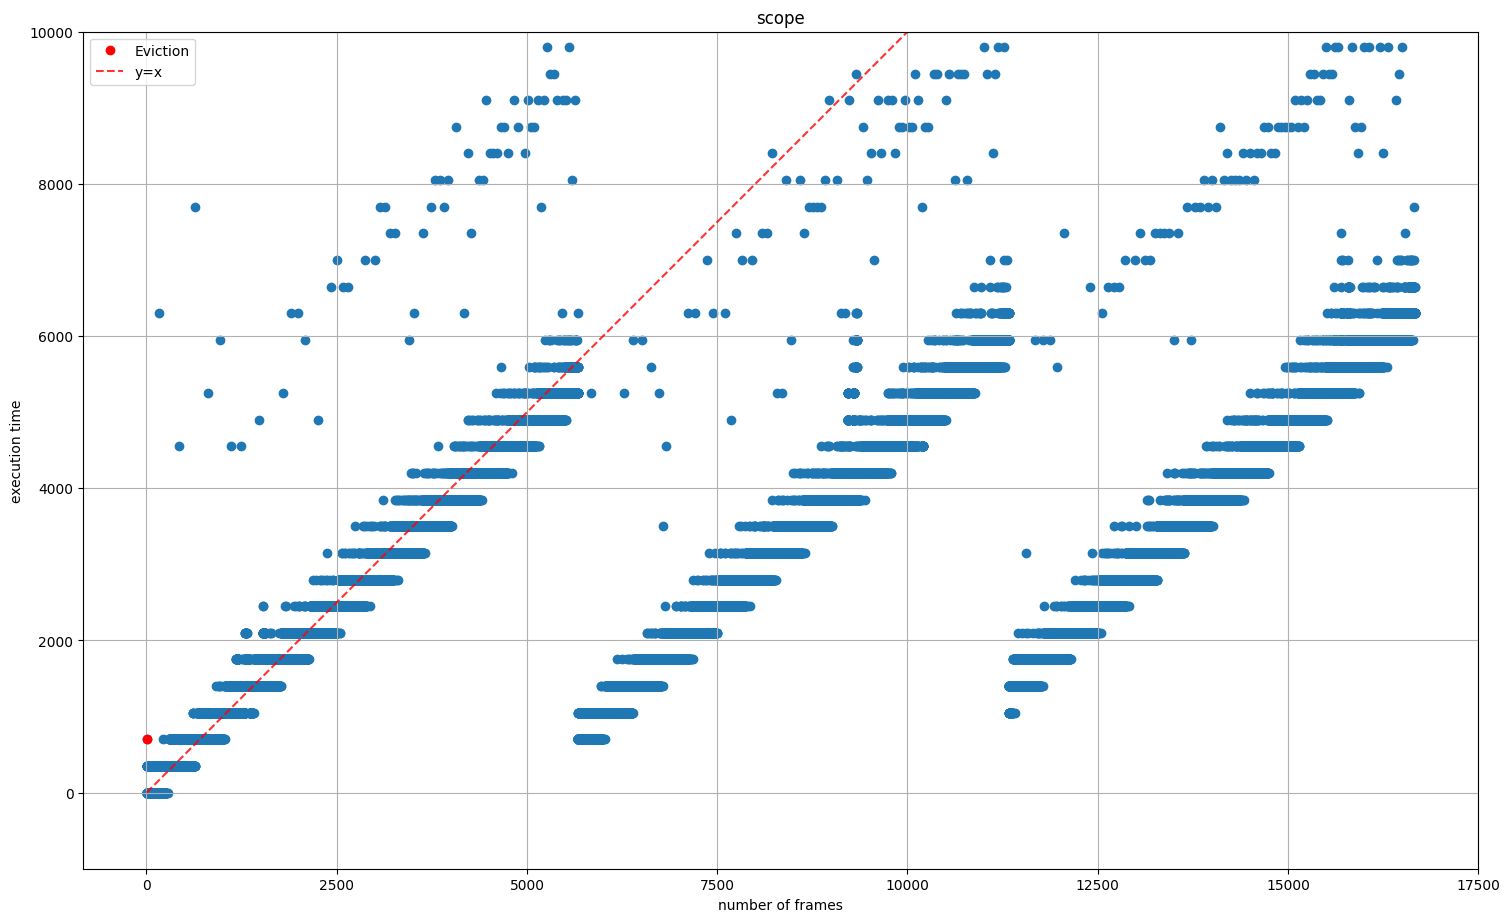

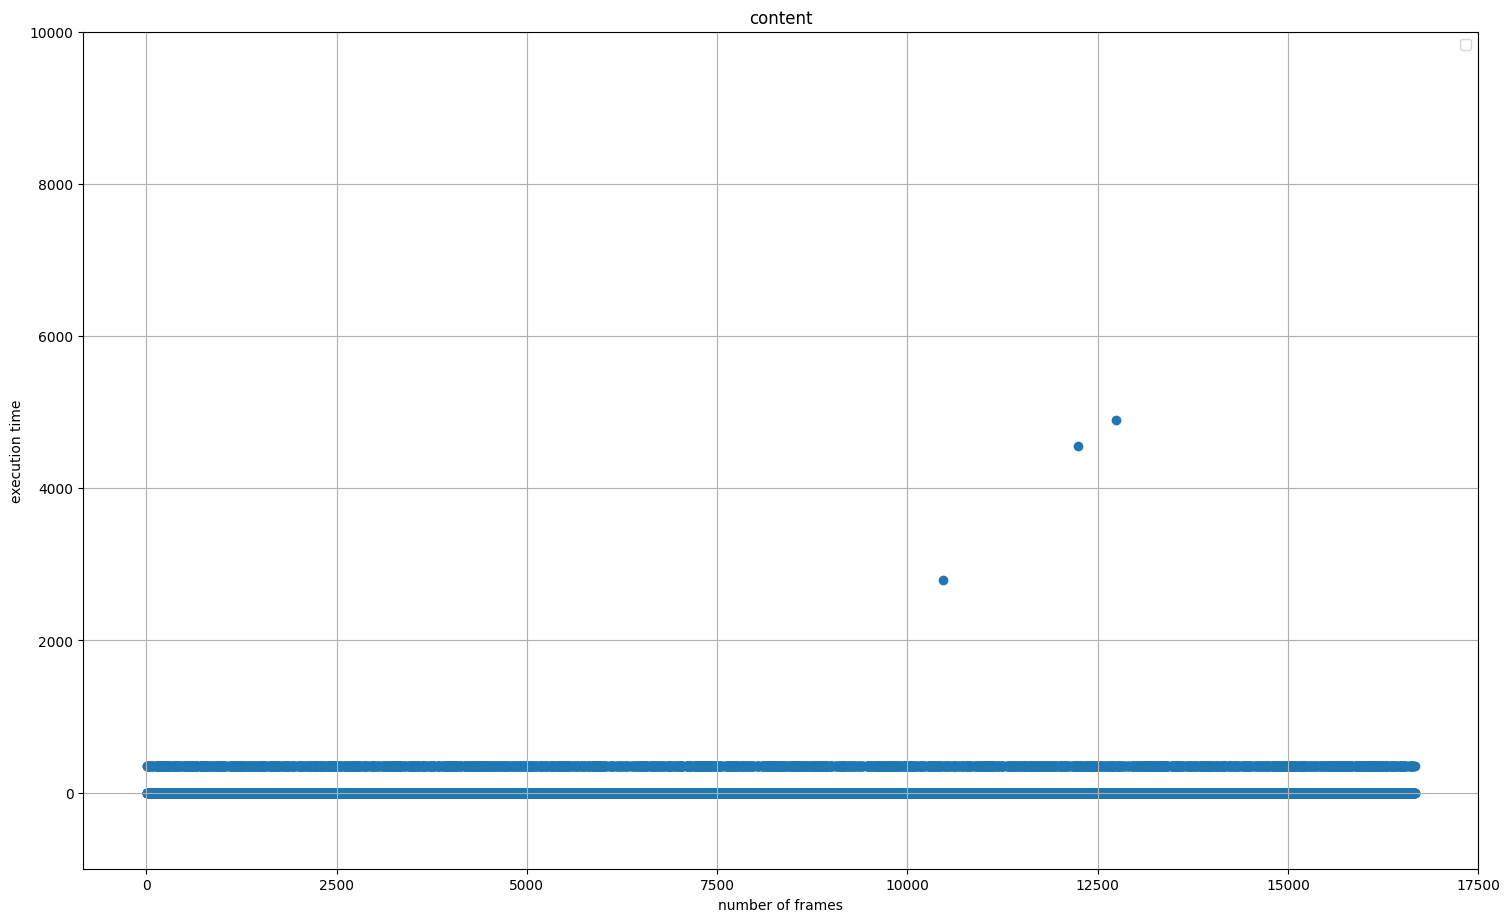

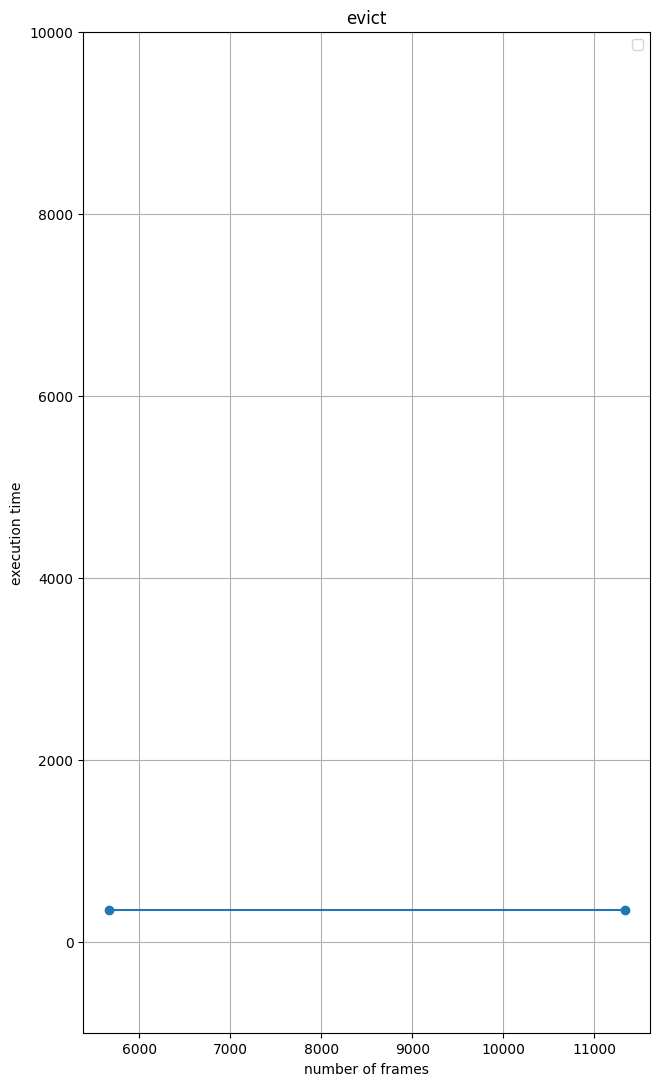

In [13]:
from pickle import FALSE
from scipy.signal import find_peaks
from scipy.stats import linregress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# select path
df = pd.read_csv(mb_e_path)

multiplier = 350000000  # time scaling for better analysis

df['add'] *= multiplier
df['scope'] *= multiplier
df['content'] *= multiplier
df['evict'] *= multiplier

methods = ['add', 'scope', 'content', 'evict']

def linear_function(x, x0, y0):
    return (x - x0) + y0

thresholds = {
    'add': {'delta_threshold': 12000, 'threshold_value': 10000},
    'scope': {'delta_threshold': 12000, 'threshold_value': 10000},
    'content': {'delta_threshold': 100000, 'threshold_value': 4000},
    'evict': {'delta_threshold': 3200, 'threshold_value': 4000}
}

for method in methods:
    method_data = df[['n', method]]

    method_data = method_data[method_data[method] != (-1 * multiplier)]

    plt.figure(figsize=(18, 13))
    if(method != 'evict'): plt.scatter(method_data['n'], method_data[method], marker='o')
    if(method == 'evict'): plt.plot(method_data['n'], method_data[method], marker='o')

    x_values = method_data['n']
    y_values = linear_function(x_values, 0, 0)


    if(method == 'scope'):
      delta_threshold = thresholds[method]['delta_threshold']
      threshold_value = thresholds[method]['threshold_value']
      discontinuity_points = [method_data.iloc[0]]

      for i in range(1, len(method_data)):
          delta = abs(method_data[method].iloc[i] - method_data[method].iloc[i - 1])
          if delta >= delta_threshold and method_data[method].iloc[i] <= threshold_value:
              discontinuity_points.append(method_data.iloc[i])

      if discontinuity_points:
          discontinuity_points = pd.DataFrame(discontinuity_points)

          plt.plot(discontinuity_points['n'], discontinuity_points[method], 'ro', label='Eviction')

          first = 0
          for n_discontinuity in discontinuity_points['n']:
              y_values_discontinuity = linear_function(x_values, n_discontinuity, 0)
              if (first == 0):
                plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8, label='y=x')
                first = 1
              else :
                plt.plot(x_values, y_values_discontinuity, linestyle='--', color='red', alpha=0.8)


    plt.grid(True)
    ax = plt.gca()

    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.title(f'{method}')
    plt.xlabel('number of frames')
    plt.ylabel(f'execution time')
    plt.ylim(-1000,10000)
    if(method != 'add'): plt.legend()

    plt.show()
